In [4]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [5]:
# Load the data from a CSV file
df = pd.read_csv("https://raw.githubusercontent.com/CUNY-CISC3440-Fall2022/datasets/main/housing.csv")

In [6]:
# Briefly review the dataframe to see what kinds of data we have:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


[]

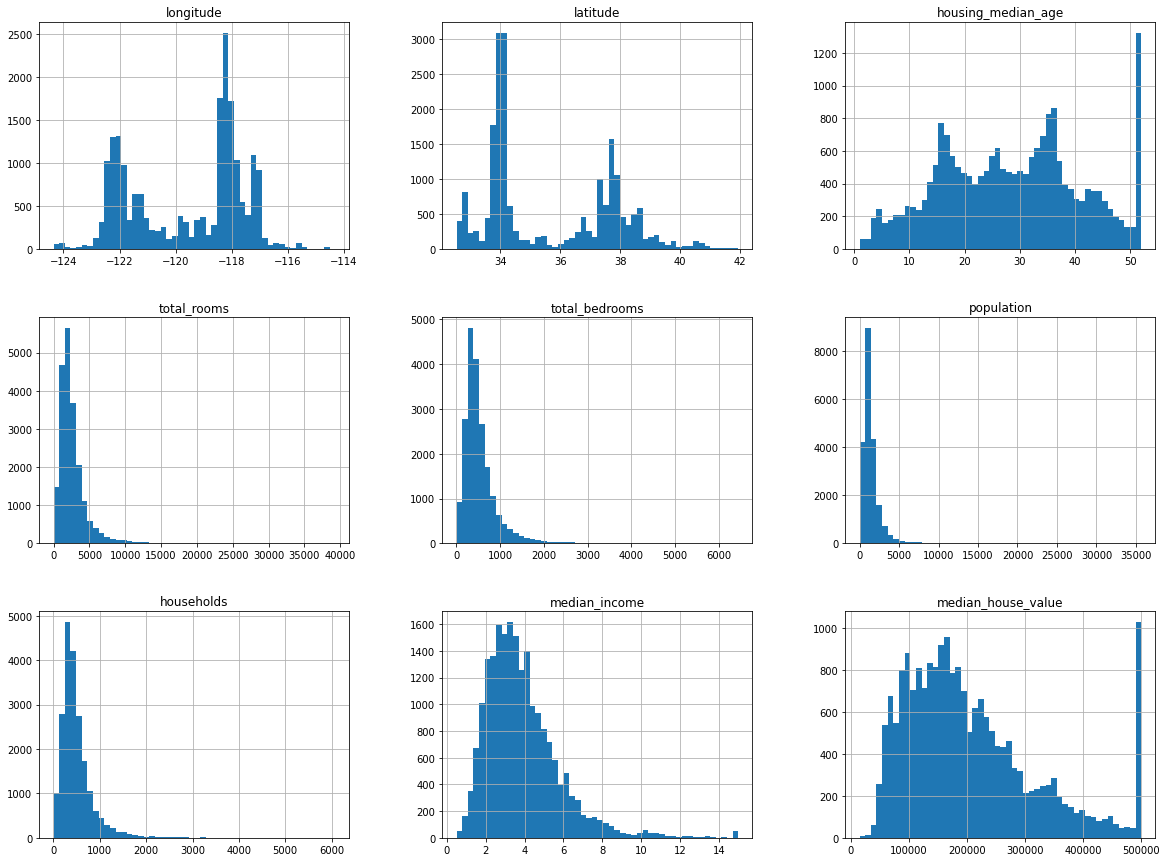

In [8]:
 # View a histogram of our data. We can get a sense of the range of values
 # contained in each variable, as well as identify potential problems for later.

df.hist(bins=50, figsize=(20,15))
plt.plot()

# From the histogram, we see the following:
#
# - Some variables (housing_median_age, median_house_value) are capped at a
#   maximum value. This could be a problem depending on the needs of the model.
#   For example, do our stakeholders expect us to predict median house values
#   accurately beyond $500,000? If so, we can't with this data!
#       - For now, we will assume it is unnecessary
# - Median income does not appear to be represented as dollars per year. For this
#   dataset, it is actually 1/10,000 of the actual value - for example, a value
#   income of 3 indicates a median income of $30,000. This is just a quirk of
#   this dataset, and we do not need to do anything to fix it.

#Step 1: Train/test split

We need to set aside data to evaluate our models once we have finished training them all. This section of the notebook shows how to do this.

We have two options, a random train/test split, or a stratified train/test split:

* The random split will randomly allocate 80% of instances into the training set and 20% into the test set.
* A stratified split will randomly allocate 80% of instances into the training set and 20% into the test set, in a way that maintains the proportions of a given value in the dataframe.

In this specific example, our hypothetical data team tells us that median income is _very_ important for determining housing value. Because of its importance, we may want to ensure we have _representative_ training data, or training data that accurately reflects the distribution of income in our data. Because of this, we may choose to use a stratified split.

In [9]:
train, test = train_test_split(df, train_size=0.8, random_state=5000)
train

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
10017,-121.21,39.24,7.0,4194.0,673.0,1355.0,566.0,4.3702,226100.0,INLAND
7654,-118.26,33.83,24.0,3059.0,NaN,2064.0,629.0,3.5518,184600.0,<1H OCEAN
10220,-117.88,33.88,15.0,957.0,360.0,615.0,370.0,3.0263,162500.0,<1H OCEAN
4698,-118.38,34.08,25.0,4625.0,1307.0,1739.0,1191.0,3.3989,485000.0,<1H OCEAN
16738,-122.42,37.71,44.0,2080.0,489.0,1781.0,478.0,3.6827,215300.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
20634,-121.56,39.27,28.0,2332.0,395.0,1041.0,344.0,3.7125,116800.0,INLAND
15163,-116.99,32.96,17.0,5509.0,866.0,2748.0,817.0,4.8854,181300.0,<1H OCEAN
7299,-118.20,33.99,35.0,1705.0,523.0,2252.0,508.0,2.3421,154200.0,<1H OCEAN
19470,-120.99,37.67,16.0,568.0,124.0,307.0,116.0,2.1518,107400.0,INLAND


In [10]:

df['income_cat']=pd.cut(
    df.median_income,
    [0, 1.5, 3.0, 4.5, 6, np.inf],
    labels=[1, 2, 3, 4, 5]
)

# Check the distribution of income buckets:
df.income_cat.value_counts()/len(df)

3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: income_cat, dtype: float64

In [11]:

splitter = StratifiedShuffleSplit(n_splits=1, train_size=.8, random_state=9000)
for train_idx, test_idx in splitter.split(df, df.income_cat):
  strat_train = df.loc[train_idx]
  strat_test = df.loc[test_idx]

print(strat_train.income_cat.value_counts()/len(strat_train))
print(strat_test.income_cat.value_counts()/len(strat_test))

3    0.350594
2    0.318859
4    0.176296
5    0.114462
1    0.039789
Name: income_cat, dtype: float64
3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: income_cat, dtype: float64


In [12]:
# For convenience, we will give our training set a better name for analysis
housing = strat_train
housing_test = strat_test

In [21]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")
housing_num = housing.drop("ocean_proximity", axis=1)
imputer.fit(housing_num)
imputer.statistics_
housing_num.median().values



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  


array([-1.1849e+02,  3.4260e+01,  2.9000e+01,  2.1285e+03,  4.3700e+02,
        1.1670e+03,  4.1100e+02,  3.5355e+00,  1.7935e+05])

#Step 2: Visualization

Visualization can help you understand the data better, and can give you insights for how to preprocess the data ore even understand how a machine learning model might learn from your data. We will visualize two aspects of the data below.

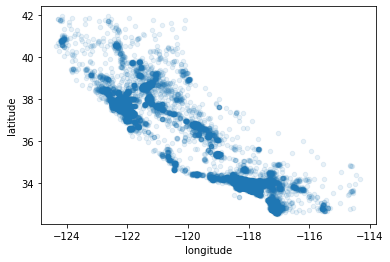

In [ ]:

housing.plot(kind="scatter", x='longitude', y='latitude', alpha=0.1)

In [ ]:

housing.corr()['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.691698
total_rooms           0.138177
housing_median_age    0.106813
households            0.068301
total_bedrooms        0.052250
population           -0.022625
longitude            -0.044050
latitude             -0.145511
Name: median_house_value, dtype: float64

[]

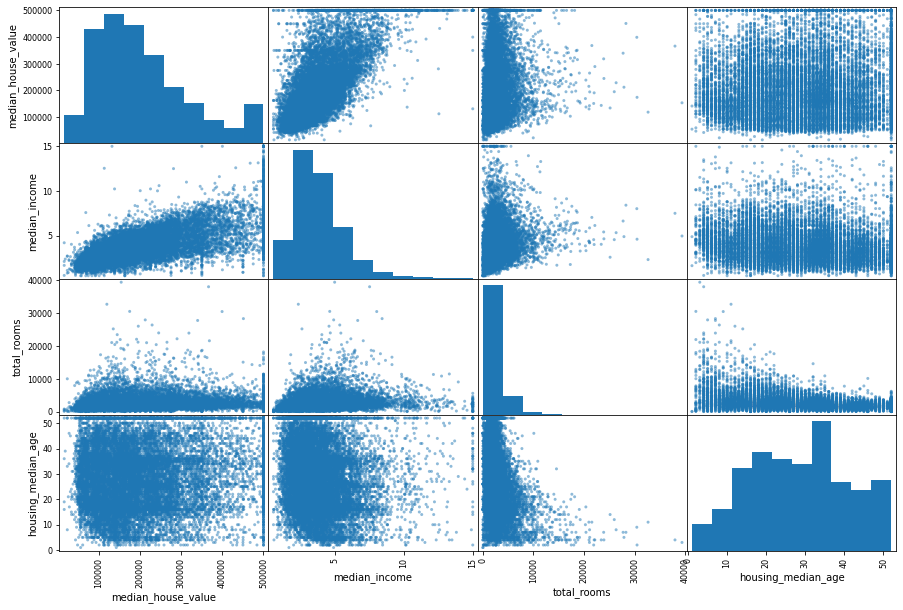

In [ ]:

scatter_matrix(housing[['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']], figsize=(15, 10))
plt.plot()

# Step 3: Preparing data for machine learning

We now have several things to do to clean up the data in preparation for a ML algorithm. These include:

- Deal with missing data
- Deal with categorical labels in the ocean_proximity variable
- Scale, or normalize, the input data

**Note**: The code below is _not modifying the dataframe_. Rather, it is demonstrating the functionality of each of the preparation steps without changing the underlying data. This notebook will use a pipeline (p. 70) to summarize these preprocessing steps and make them happen all at once in a reusable way.

In [34]:

one_hot_encoder = OneHotEncoder()
one_hot_encoder.fit_transform(housing[['ocean_proximity']]).toarray()

array([[0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.]])

In [33]:
# Deal with missing values from the total_bedrooms column. We have several options
# for dealing with missing values. We can drop rows with missing values...
print("Original housing dataframe length: ", len(housing))
housing.dropna().info()

Original housing dataframe length:  16512
<class 'pandas.core.frame.DataFrame'>
Int64Index: 16346 entries, 2030 to 7954
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   longitude           16346 non-null  float64 
 1   latitude            16346 non-null  float64 
 2   housing_median_age  16346 non-null  float64 
 3   total_rooms         16346 non-null  float64 
 4   total_bedrooms      16346 non-null  float64 
 5   population          16346 non-null  float64 
 6   households          16346 non-null  float64 
 7   median_income       16346 non-null  float64 
 8   median_house_value  16346 non-null  float64 
 9   ocean_proximity     16346 non-null  object  
 10  income_cat          16346 non-null  category
dtypes: category(1), float64(9), object(1)
memory usage: 1.4+ MB


In [32]:
# ...Or we can drop entire columns with missing values...
housing.dropna(axis=1).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 2030 to 7954
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   longitude           16512 non-null  float64 
 1   latitude            16512 non-null  float64 
 2   housing_median_age  16512 non-null  float64 
 3   total_rooms         16512 non-null  float64 
 4   population          16512 non-null  float64 
 5   households          16512 non-null  float64 
 6   median_income       16512 non-null  float64 
 7   median_house_value  16512 non-null  float64 
 8   ocean_proximity     16512 non-null  object  
 9   income_cat          16512 non-null  category
dtypes: category(1), float64(8), object(1)
memory usage: 1.3+ MB


In [31]:
# but in this case, we will replace the missing value with the median house
# value. This is how we did it in class:
housing[['total_bedrooms']].fillna(housing[['total_bedrooms']].median()).info()
# (add inplace=True and remove the info() call to replace it in the original dataset)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 2030 to 7954
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   total_bedrooms  16512 non-null  float64
dtypes: float64(1)
memory usage: 258.0 KB


In [30]:
# And this is how we can replace it automatically with more advanced
# SciKit-Learn functionality:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')

# The imputer works automatically on all numeric columns. To ensure
# it works, we have to drop non-numeric columns from the dataframe.
imputer.fit_transform(housing.drop('ocean_proximity', axis=1))

# The imputer creates a NumPy array, so the output is no longer
# a nice Pandas dataframe. However, all null values in this array
# have been replaced by the median.

array([[-1.1974e+02,  3.6720e+01,  2.5000e+01, ...,  2.1304e+00,
         5.8500e+04,  2.0000e+00],
       [-1.2145e+02,  3.8560e+01,  5.2000e+01, ...,  4.6300e+00,
         2.3380e+05,  4.0000e+00],
       [-1.1811e+02,  3.4100e+01,  4.4000e+01, ...,  3.3229e+00,
         2.2660e+05,  3.0000e+00],
       ...,
       [-1.2226e+02,  3.7860e+01,  5.2000e+01, ...,  2.9044e+00,
         2.5740e+05,  2.0000e+00],
       [-1.1688e+02,  3.4080e+01,  5.2000e+01, ...,  3.9028e+00,
         1.2860e+05,  3.0000e+00],
       [-1.1816e+02,  3.3870e+01,  3.2000e+01, ...,  2.6406e+00,
         1.5670e+05,  2.0000e+00]])

In [29]:

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit_transform(housing.drop('ocean_proximity', axis=1))

array([[-0.08419219,  0.50793673, -0.28387592, ..., -0.91482259,
        -1.28326179, -0.95468705],
       [-0.93473598,  1.36779147,  1.86107771, ...,  0.39696535,
         0.23352747,  0.94182312],
       [ 0.72656007, -0.71642166,  1.2255359 , ..., -0.28899961,
         0.17122922, -0.00643196],
       ...,
       [-1.33762514,  1.04067282,  1.86107771, ..., -0.50862805,
         0.43772728, -0.95468705],
       [ 1.33835473, -0.72576791,  1.86107771, ...,  0.01533141,
        -0.67671914, -0.00643196],
       [ 0.70169037, -0.8239035 ,  0.27222317, ..., -0.64707007,
        -0.43358292, -0.95468705]])

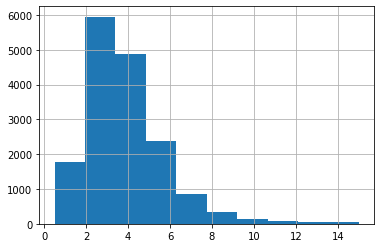

In [45]:
housing["median_income"].hist()
    

In [35]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.691698
total_rooms           0.138177
housing_median_age    0.106813
households            0.068301
total_bedrooms        0.052250
population           -0.022625
longitude            -0.044050
latitude             -0.145511
Name: median_house_value, dtype: float64

Training and validation set

In [106]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(X=X_train, y=y_train)
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

KNeighborsClassifier()

In [46]:
predicted = knn.predict(X=X_test)
expected = y_test
predicted[:20]


array([0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0])

In [48]:
expected[:20]



512    0
457    1
439    1
298    1
37     1
515    1
382    1
310    1
538    1
345    1
421    1
90     1
412    1
157    1
89     1
172    0
318    1
233    0
389    0
250    0
Name: target, dtype: int64

In [49]:
wrong = [(p, e) for (p, e) in zip(predicted, expected) if p != e]


In [50]:
wrong


[(0, 1), (0, 1), (0, 1), (1, 0), (0, 1), (1, 0), (1, 0), (0, 1), (1, 0)]

In [41]:
print(f'{knn.score(X_test, y_test):.2%}')

93.71%


In [51]:
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(y_true=expected, y_pred=predicted)
confusion


array([[49,  4],
       [ 5, 85]])

Classifier

In [91]:
models = {}
from sklearn.ensemble import RandomForestClassifier
models['Random Forest'] = RandomForestClassifier()

from sklearn.svm import LinearSVC
models['Support Vector Machines'] = LinearSVC()

from sklearn.neighbors import KNeighborsClassifier
models['K-Nearest Neighbor'] = KNeighborsClassifier()


In [92]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

accuracy, precision, recall = {}, {}, {}

for key in models.keys():
    
    # Fit the classifier
    models[key].fit(X_train, y_train)
    
    # Make predictions
    predictions = models[key].predict(X_test)
    
    # Calculate metrics
    accuracy[key] = accuracy_score(predictions, y_test)
    precision[key] = precision_score(predictions, y_test)
    recall[key] = recall_score(predictions, y_test)
    

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


In [93]:
import pandas as pd

df_model = pd.DataFrame(index=models.keys(), columns=['Accuracy', 'Precision', 'Recall'])
df_model['Accuracy'] = accuracy.values()
df_model['Precision'] = precision.values()
df_model['Recall'] = recall.values()

df_model

,Accuracy,Precision,Recall
Random Forest,0.965035,0.966667,0.977528
Support Vector Machines,0.944056,0.988889,0.927083
K-Nearest Neighbor,0.937063,0.944444,0.955056


Random Forest classifier performed best with Accuracy, precision and Recall value. It perfomer with high precision and accuracy.

In [99]:
y_train_5 = (y_train == 5) # True for all 5s, False for all other digits
y_test_5 = (y_test == 5)

from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)  

from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)
y_train_perfect_predictions = y_train_5 # pretend we reached
perfection
confusion_matrix(y_train_5, y_train_perfect_predictions)


ValueError: ignored

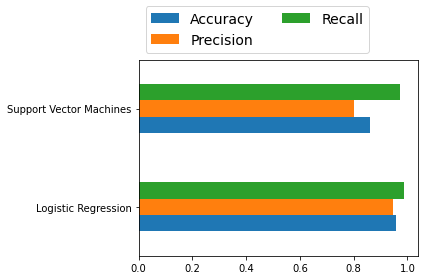

In [68]:
ax = df_model.plot.barh()
ax.legend(
    ncol=len(models.keys()), 
    bbox_to_anchor=(0, 1), 
    loc='lower left', 
    prop={'size': 14}
)
plt.tight_layout()

# Step 4: Tying it all together

The notebook cells shown above demonstrated different preprocessing steps needed to prepare the data for machine learning _without modifying the original data_. This section actually implements those steps in the form of a sklean transformation pipeline.

This pipeline is adapted from the book, but omits the step where new features are engineered to create rooms per house, bedrooms per house, and population per house. You are encouraged to experiment with creating and omitting these variables and seeing how they impact different ML algorithms!

In [36]:
# The processing pipeline handles numeric columns and textual columns differently.
# Specifically, for the numeric columns, we have to carry out the following steps:
#   - Fill in missing values
#   - Scale
# For categorical columns (ocean proximity), we have to carry out the following
# steps:
#   - Use one-hot encoding to replace the text labels with numbers
#   - Combine the one-hot-encoded labels with the numeric values
#
# To do this, we will define the numeric columns we care about.
#
# NOTE: median_house_value is NOT part of this pipeline!
# We DO NOT want to preprocess it - it is the value our ML models are trying to
# predict, so we should leave it alone!
numeric_columns = ['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income']

# Pipeline imports
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

# Pipeline for numeric values: First replace missing values, then scale.
# If you decide to try creating the rooms_per_household, population_per_household,
# and bedrooms_per_room, it would be added to the pipeline here.
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scale', StandardScaler())
])

# Create the entire pipeline: Carry out the numeric pipeline on the numeric
# columns of the dataset, then concatenate its output with the output of a one-
# hot encoder for ocean_proximity.
full_pipeline = ColumnTransformer([
    ('numeric', numeric_pipeline, numeric_columns),
    ('cat', OneHotEncoder(), ['ocean_proximity'])
])

# Now the pipeline is complete. We can create the final housing input data. Like
# before, this is now a NumPy array, not a Pandas dataframe, so we no longer have
# nice column labels
housing_prepared = full_pipeline.fit_transform(housing)

#Transform the test data using the pipeline
housing_test_prepared = full_pipeline.transform(housing_test)

housing_prepared

array([[-0.08419219,  0.50793673, -0.28387592, ...,  0.        ,
         0.        ,  0.        ],
       [-0.93473598,  1.36779147,  1.86107771, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.72656007, -0.71642166,  1.2255359 , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.33762514,  1.04067282,  1.86107771, ...,  0.        ,
         1.        ,  0.        ],
       [ 1.33835473, -0.72576791,  1.86107771, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.70169037, -0.8239035 ,  0.27222317, ...,  0.        ,
         0.        ,  0.        ]])

In [38]:
# In this cell, we do a simple train/validation split on the training data
# to evaluate our model.

# Define X (inputs) and y (target values) for a machine learning algorithm
X = housing_prepared
y = housing['median_house_value']

# Split the training data
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size = 0.8, random_state=2000)

# Now finally, after all this work, we can train a linear regressor:
linear_regressor = LinearRegression()
linear_regressor.fit(X_train, y_train)

# Evaluate the linear regressor
y_pred = linear_regressor.predict(X_val)
linear_regressor_rmse = mean_squared_error(y_val, y_pred, squared=False)
linear_regressor_rmse

72215.95377352658

In [ ]:
# As an alternative to a simple train/validation split, we can use a cross
# validator score. In this case, we perform a 10-fold cross validation on the
# regressor, using the root mean squared error as our scoring method.
#
# The score is negated because this is how sklearn's cross-validation system works.
# It is only an incidental concern for this score (we just have to negate it), but
# it is used in some cases where sklearn identifies a well-performing mode.
linear_regressor_cv_rmse_scores = -cross_val_score(linear_regressor, X, y, cv=10, scoring="neg_root_mean_squared_error")

# Print statistics about the score
print("Mean", np.mean(linear_regressor_cv_rmse_scores))
print("Standard Deviation", np.std(linear_regressor_cv_rmse_scores))
print(linear_regressor_cv_rmse_scores)

Mean 68718.09210727029
Standard Deviation 2053.475707089179
[71365.27609663 70726.86898807 70884.43459786 69237.46045535
 65488.21736742 68536.68457693 69574.4965421  64933.62467075
 68480.67393028 67953.18384731]


In [53]:
# Trying again with a different regressor:

rf = RandomForestRegressor()

rf_cv_rmse_scores = -cross_val_score(rf, X, y, cv=10, scoring="neg_root_mean_squared_error")

# Print statistics about the score
print("Mean", np.mean(rf_cv_rmse_scores))
print("Standard Deviation", np.std(rf_cv_rmse_scores))
print(rf_cv_rmse_scores)

Mean 48686.921626339754
Standard Deviation 1366.2393838738692
[49566.06220296 47465.61034027 50250.76641889 48745.98549027
 47944.59139708 47674.98673228 51202.01346398 47586.84218054
 49699.14677123 46733.21126591]


In [39]:
# The RandomForestRegressor performed the best: A mean error of about
# 48638 versus 68718. So out of these two models, we will select it as the best
# one to predict housing prices.
#
# As a final evaluation, we will test the RandomForestRegressor on the
# test set to get a sense of how it will perform on completely unseen data:
#
# Train on all training data:
rf = RandomForestRegressor()

rf.fit(X, y)
# Predict the test set:
final_predict = rf.predict(housing_test_prepared)
# Final evaluation:
mean_squared_error(final_predict, housing_test['median_house_value'], squared=False)

49224.125748182334